In [8]:
import tensorflow as tf
from ipywidgets import IntProgress
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from itertools import chain
import pandas as pd
import seaborn as sns

In [2]:
class CIFAR():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
        
    
    def _load_traing_data(self):
        for i in range(1, 6):
            path = os.path.join(self._directory, "data_batch_" + str(i))
            with open(path, 'rb') as fd:
                cifar_data = pickle.load(fd, encoding = "bytes")
                imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
                imgs = imgs.transpose([0, 2, 3, 1])
                if i == 1:
                    self._training_data = imgs
                    self._training_labels = cifar_data[b"labels"]
                else:
                    self._training_data = np.concatenate([self._training_data, imgs], axis = 0)
                    self._training_labels = np.concatenate([self._training_labels, cifar_data[b"labels"]])
    
    def _load_test_data(self):
        path = os.path.join(self._directory, "test_batch")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"labels"])
    
    def get_training_batch(self, batch_size, numC,numCMax=0,balanced=True):
        if balanced:
            return self._get_batch(self._training_data[np.where(self._training_labels<=numC)], self._training_labels[np.where(self._training_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._training_data[np.where((self._training_labels==numC)&(self._training_labels==numCMax))], self._training_labels[np.where((self._training_labels==numC)&(self._training_labels==numCMax))], batch_size)
    def get_validation_batch(self, batch_size, numC,numCMax=0,balanced=True):
        if balanced:
            return self._get_batch(self._validation_data[np.where(self._validation_labels<=numC)], self._validation_labels[np.where(self._validation_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._validation_data[np.where((self._validation_labels==numC)&(self._validation_labels==numCMax))], self._validation_labels[np.where((self._validation_labels==numC)&(self._validation_labels==numCMax))], batch_size)
    
    def get_test_batch(self, batch_size,numC):
        return self._get_batch(self._test_data[np.where(self._test_labels<=numC)], self._test_labels[np.where(self._test_labels<=numC)], batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    

In [3]:
#path = "C:/Vivi's Dateien/Dropbox/"
path = "C:/Users/vivia/Dropbox/"
#path = "/Users/ingen/Dropbox/"
cifar = CIFAR(path + "Uni2/TensorFlow/Excercises/cifar-10-python/cifar-10-batches-py")

[4 1 8 5 7 3 2 9 0 6]


<Figure size 1440x720 with 0 Axes>

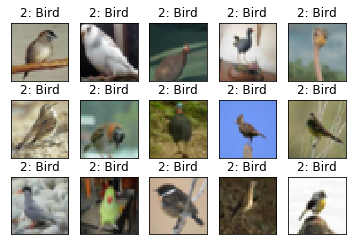

In [5]:
Llist = np.random.permutation(10)
print(Llist)
#images, labels = next(cifar.get_validation_batch(15,5,Llist))
images, labels = next(cifar.get_training_batch(15,2,2,balanced=False))
label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(str(labels[i]) + ": " + label_to_word[labels[i]])
plt.show()

In [6]:
def printAll(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
        print(v.name)
def getNames(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v.name)
    return lst_vars
def getTensors(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
    return lst_vars
def getUnititialized(allVars):
    uninitialized_vars = []
    for var in allVars:
        try:
            session.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)
    return uninitialized_vars
def getSubSet(toFreeze,All):
    for var in toFreeze:
        All.remove(var)
    return All
def OwnAccuracyCalculator(out,target,maxOld):
    numRight = 0
    RightNew = 0
    RightOld = 0
    WrongNew = 0
    WrongOld = 0
    for i,e in enumerate(out):
        label = np.argmax(e)       
        if target[i]<maxOld:         
            if label==target[i]:
                numRight = numRight+1
                RightOld = RightOld+1
            else:
                WrongOld = WrongOld+1
        else:
            if label==target[i]:
                numRight = numRight+1
                RightNew = RightNew+1
            else:
                WrongNew = WrongNew+1            
    AccAll = numRight/out.shape[0]
    AccOld = RightOld/(RightOld+WrongOld)
    try:
        AccNew = RightNew/(RightNew+WrongNew)
    except:
        AccNew = 0
    return AccAll,AccOld,AccNew
def smoothListGaussian(list,strippedXs=False,degree=5):  
    #Code from https://www.swharden.com/wp/2008-11-17-linear-data-smoothing-in-python/
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed
def perfQuantifier(accs,esteps,smooth=True):
    if smooth:
        smoothacc = smoothListGaussian(accs,degree=20)
    else:
        smoothacc = accs
    numEpochs = esteps.shape[0]
    plateauStart = np.zeros((esteps.shape[0]-1))
    pleateau = np.zeros((esteps.shape[0]-1))
    mins = np.zeros((esteps.shape[0]-1))
    for i in range(numEpochs-1):
        part = smoothacc[esteps[i]:esteps[i+1]]
        tenpermax = max(part)-0.02#plateau starts when max-2% is reached
        #max(part)-(max(part)-min(part))/4#get threshold of 10% below maximum
        pleateau[i] = tenpermax
        plateauStart[i] = np.where(part>tenpermax)[0][0]
        mins[i] = np.min(accs[esteps[i]:esteps[i+1]])
    return plateauStart,pleateau,mins
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm
#Plotting -------------------------------------------------------------------------------------------------------------
def plotPerformance(training_accuracies,validation_accuracies,steps,testacc,title):
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(3,2,hspace=0.4, wspace=0.4)
    fig.add_subplot(grid[:2,:])
    plt.plot(training_accuracies)
    plt.plot(np.append(validation_accuracies,validation_accuracies[-1]), linewidth=5)
    plt.plot(np.full(steps[-1],testacc), linewidth=3, color = 'black')
    plt.xlabel("Training Step", fontsize=18)
    plt.ylabel("Accuracy in %", fontsize=18)
    plt.title(title, fontsize=18)
    plt.xlim(0,steps[-1]-10)
    plt.ylim(0,1)
    plt.legend(['training','validation','Test-Accuracy: '+str(testacc)],fontsize=20,loc=3)
    start,v,mini = perfQuantifier(training_accuracies,steps)
    for s in steps:
        plt.axvline(x=s,color='r')
    for i in range(steps.shape[0]-1):
        plt.plot(np.linspace(steps[i],steps[i+1],steps[i+1]-steps[i]),np.full(steps[i+1]-steps[i],v[i]), linewidth=2, color = 'green')
        plt.axvline(x=steps[i]+start[i],color='green')
    plt.scatter(steps[:-1],mini,color='r')

    fig.add_subplot(grid[2,0])
    plt.bar(np.linspace(0,start.shape[0]-1
                        ,start.shape[0]),start)
    plt.title("Steps until Convergance in Reached (Max-2%)", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Number of Steps", fontsize=18)
    plt.xticks(np.linspace(0,start.shape[0]-1,start.shape[0]), np.linspace(0,start.shape[0]-1,start.shape[0])) 
    fig.add_subplot(grid[2,1])
    plt.bar(np.linspace(0,mini.shape[0]-1,mini.shape[0]),mini)
    plt.ylim(0,1)
    plt.title("Minimum Performance in this Training Cycle", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Performance in %", fontsize=18)
    plt.xticks(np.linspace(0,mini.shape[0]-1,mini.shape[0]), np.linspace(0,mini.shape[0]-1,mini.shape[0]))

def createNodeImg(NIn,NOut):
    AllOut = []
    for i in range(NOut):
        node = np.full(NIn,i)
        AllOut = np.append(AllOut,node)
    return AllOut
def plotWeights(weights,NIn,NOut):
    nodeRef = createNodeImg(NIn,NOut)
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(weights.reshape((NIn*NOut)//(NOut*8),NOut*8),vmin=-0.05,vmax=0.05)
    ax.set_title("Weights for "+str(NOut)+" Output Nodes")
    plt.colorbar()
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(nodeRef.reshape((NIn*NOut)//(NOut*8),NOut*8))
    ax2.set_title("Reference for Nodes")
def plotOutDist(vlabels,out):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(vlabels,bins=out.shape[1])
    plt.title("Label Distribution")
    plt.subplot(1,2,2)
    plt.hist(np.argmax(out,axis=1),bins=out.shape[1])
    plt.title("Output Distribution")
def plotViolinWeights(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    fig = plt.figure(figsize=(15,5))
    sns.violinplot(x="groups", y="vals", data=wdf)
    plt.xlabel("Inputs to Class Node X",fontsize=18)
    plt.ylabel("Weights",fontsize=18)
    plt.title(title,fontsize=18)
def plotViolinWeightsAx(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    ax = sns.violinplot(x="groups", y="vals", data=wdf)
    ax.set_xlabel("Inputs to Class Node X",fontsize=18)
    ax.set_ylabel("Weights",fontsize=18)
    ax.set_title(title,fontsize=18)
    return ax

## Network Growing with Unbalanced Data Sets
Here: 50% of the training set is made up of the new class. Can be change in "percNew".

In [21]:
numExperiments = 100
epochs = 1 #Number of epochs in each block (how often is the training set itterated before a new class is added)
newClasses = 6 #Number of new classes introduced
KeepTrain = 0
preTrain = 2
percNew = 0.5

mini_batch_size = 200
plot_step_size = 10
training_steps = cifar.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
validation_cross_entropies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))

training_accuracies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
val_accuracies_old = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
val_accuracies_new = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
validation_accuracies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
testaccs = np.zeros(numExperiments)
allOuts = []
allTargets = []

ESteps = [0]
exN = IntProgress(min=0, max=numExperiments) # instantiate the bar
display(exN) # display the bar

for exp in range(numExperiments):
    numC=6 #Number of classes in the beginning of training
    numOutP=6 #Number of classes at the beginning of training
    
    outName = 'LastLayer/add:0'
    tf.reset_default_graph()
    
    weightName = 'LastLayer/weights_4'+str(numOutP)+':0'
    x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    desired = tf.placeholder(tf.int64, shape = [None])

    normx = tf.layers.batch_normalization(x)

    with tf.variable_scope("model",reuse=tf.AUTO_REUSE):

        kernels_1 = tf.get_variable("kernels_1",shape=[5, 5, 3,16],initializer=tf.truncated_normal_initializer(stddev = 0.1))
        convolution_1 = tf.nn.conv2d(normx, kernels_1, strides = [1, 1, 1,1], padding = "SAME", name="convolution_1")

        biases_1 = tf.get_variable("biases_1",[16],initializer=tf.constant_initializer(0.0))
        feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1, name="feature_maps_1")

        pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_1")

        kernels_2 = tf.get_variable("kernels_2",[3, 3, 16, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
        convolution_2 = tf.nn.conv2d(tf.layers.batch_normalization(pool_1), kernels_2, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_2")

        biases_2 = tf.get_variable("biases_2",[32],initializer=tf.constant_initializer(0.0))
        feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2, name="feature_maps_2")

        pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_2")

        flattened = tf.reshape(tf.layers.batch_normalization(pool_2), [-1, 8 * 8 * 32], name="flattened")

        startVars2 = getTensors(tf.global_variables())

        weights_3 = tf.get_variable("weights_3",[2048, 512],initializer=tf.truncated_normal_initializer(stddev = 1568**(-1/2)))
        biases_3 = tf.get_variable("biases_3",[512],initializer=tf.constant_initializer(0.0))
        hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3, name="hidden_layer")
    #startVars2 = getTensors(tf.global_variables()) # uncomment to only retrain last layer
    startVars = getTensors(tf.global_variables())
    def newLast(hiddenIn,numOut):
        with tf.variable_scope("LastLayer",reuse=False):
            weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.truncated_normal_initializer(stddev = 512**(-1/2)))
            biases_4 = tf.get_variable('biases_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
            output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
        return output_layer_logits,weights_4

    def newLastInit(hiddenIn,numOut,init):
        with tf.variable_scope("LastLayerInit",reuse=False):
            weights_4 = tf.get_variable('weightsI_4'+str(numOut),[512,numOut],initializer=init)
            biases_4 = tf.get_variable('biasesI_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
            output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
        return output_layer_logits,weights_4

    def evaluate(outLogs,desired):    
        with tf.variable_scope("eval",reuse=tf.AUTO_REUSE):
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = outLogs)
            accuracy = tf.equal(tf.argmax(tf.nn.softmax(outLogs), 1), desired)
        return accuracy,cross_entropy

    with tf.variable_scope(tf.get_variable_scope()):
        outLog,w4 = newLast(hidden_layer,numOutP)
        acc,CE = evaluate(outLog,desired)

    accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
    cross_entropy = tf.reduce_mean(CE)

    learning_rate = 1e-4
    optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')
    training_step = optimizer.minimize(cross_entropy)
    gradient = tf.gradients(cross_entropy, w4)[0]
    #startVars = getTensors(tf.global_variables())
    DontFreezeList = getSubSet(startVars2,startVars)

    #-------------------------------------------------
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(tf.global_variables_initializer())
        step = 0
        for nC in range(newClasses+KeepTrain):             
            last_step = False
            if (nC>=preTrain) & (nC<newClasses):
                DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
                initializer = tf.constant_initializer(np.append(weights,np.random.choice(weights.flatten(),(512,1)),axis=1))
                
                with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                    outLog,Wname = newLastInit(hidden_layer,numOutP,initializer)
                    acc,CE = evaluate(outLog,desired)
                    accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                    cross_entropy = tf.reduce_mean(CE)
                    learning_rate = 1e-4
                    optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

                weightName = Wname
                gradient = tf.gradients(cross_entropy, weightName)[0]
                newVars = getUnititialized(tf.all_variables())
                DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
                #training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)#Only train part of network
                training_step = optimizer.minimize(cross_entropy)#keep training all
                uninitialized_vars = getUnititialized(tf.all_variables())
                init_new_vars_op = tf.initialize_variables(uninitialized_vars)
                session.run(init_new_vars_op)
            else:
                newVars = []
            s = 0
            for epoch in range(epochs):
                if nC<preTrain:
                    bal = True
                    firstBatchSize = mini_batch_size
                else:
                    bal = False
                    firstBatchSize = int(mini_batch_size*(percNew-0.1))
                for images, labels in cifar.get_training_batch(firstBatchSize,numC-1,numC-1,balanced=bal):
                    if nC>=preTrain:
                        imNoBal, labNoBal = next(cifar.get_training_batch(int(mini_batch_size*(1-percNew+0.1)),numC-2,numC-2,balanced=True))
                        images = np.vstack((images,imNoBal))
                        labels = np.hstack((labels,labNoBal))
                    if s == 0:
                        training_cross_entropies[step,exp], training_accuracies[step,exp],FirstOut,Firstweights,Firstgrad = session.run(
                        [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: images, desired: labels}
                    )
                        FirstL = labels
                    s = s+1
                    training_cross_entropies[step,exp], training_accuracies[step,exp], _ ,trainOut= session.run(
                        [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: images, desired: labels}
                    )
                    
                    allOuts.append(trainOut)
                    allTargets.append(labels)
                    if step == (training_steps * epochs * newClasses)-(training_steps+4):
                        last_step = True

                    if step % plot_step_size == 0 or last_step:
                        images, vlabels = next(cifar.get_validation_batch(0,numC-1))

                        validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                            [cross_entropy, accuracy,outLog,weightName,gradient],
                            feed_dict = {x: images, desired: vlabels}
                        )

                        if step != 0:
                            on = step - plot_step_size if not last_step else step - plot_step_size + 1
                            off = on + plot_step_size
                            validation_cross_entropies[on:off,exp] = [validation_cross_entropy] * plot_step_size
                            validation_accuracies[on:off,exp] = [validation_accuracy] * plot_step_size
                        Aall,old,new = OwnAccuracyCalculator(out,vlabels,numC-1)
                        val_accuracies_old[step,exp] = old               
                        val_accuracies_new[step,exp] = new
                    step += 1
                    """if ((bal==False)&(nC>preTrain-1)):#step % 1 == 0:
                        #print(step)
                        bal = True
                    else:
                        bal = False"""
            if (nC < (newClasses-1))&((nC>=preTrain-1)):
                numC = numC+1 #increase number of classes in the dataset
                numOutP = numOutP +1 #increase number of output neurons
                
            ESteps = np.append(ESteps,step)
        images, testlabels =next(cifar.get_test_batch(0,numC-1))
        testaccs[exp],grad= session.run([accuracy,gradient],feed_dict = {x: images, desired: testlabels})
        exN.value += 1

IntProgress(value=0)

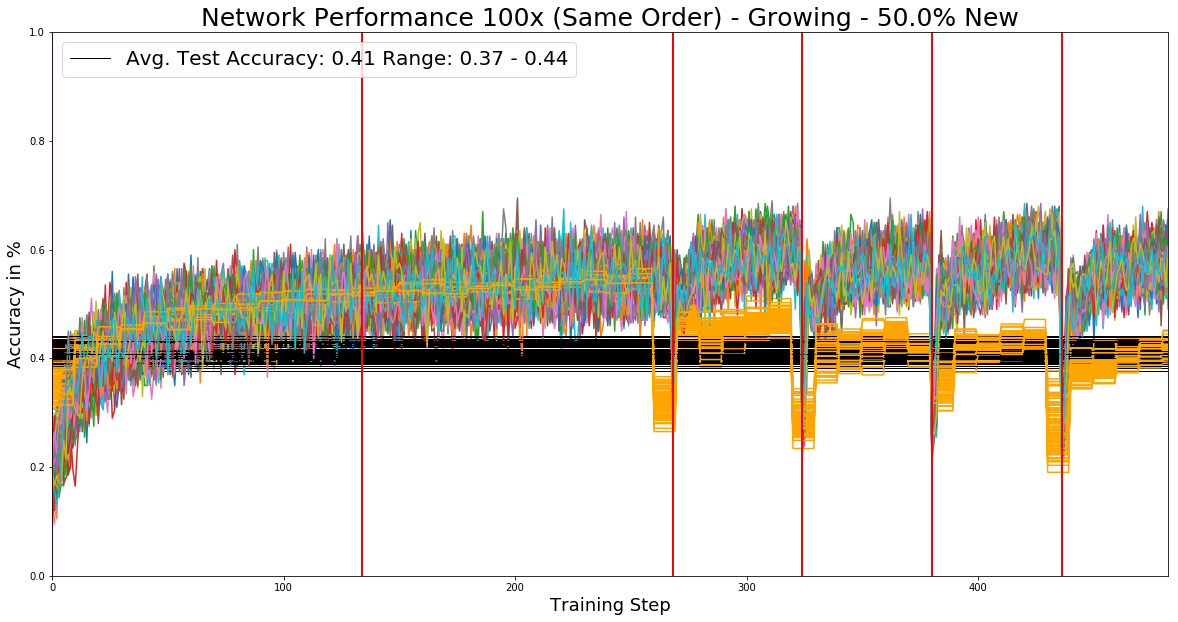

In [23]:
#np.save('NewResults/Grow50Per.npy',testaccs)
plt.figure(figsize=(20,10))
for e in range(numExperiments):
    plt.plot(np.full(ESteps[-1],testaccs[e]), linewidth=1, color = 'black')
    plt.plot(training_accuracies.T[e])
    plt.plot(validation_accuracies.T[e],'orange')
    
plt.legend(['Avg. Test Accuracy: '+str(np.mean(testaccs))[:4]+" Range: "+str(min(testaccs))[:4]+" - "+str(max(testaccs))[:4]],fontsize=20)

plt.xlabel("Training Step", fontsize=18)
plt.ylabel("Accuracy in %", fontsize=18)
plt.title("Network Performance 100x (Same Order) - Growing - "+str(percNew*100)+"% New", fontsize=25)
plt.xlim(0,ESteps[-1]-10)
plt.ylim(0,1)
for e in ESteps:
    plt.axvline(x=e,color='r')
#plt.savefig("NewResults/CIFAR_Grow_NoShuffle100_20PerNew.png", bbox_inches='tight')
plt.show()

## Plot Result Comparison
Either run the above code under all conditions you want to compare and save the data in a data frame or use the data frame generated by me called TestAccuracies.csv.

In [20]:
testaccs = pd.read_csv('NewResults/TestAccuracies.csv')[['Condition','Freeze','KeepTrain','Performance']]
PerComp = testaccs[(testaccs['Condition']=='Grow - 20%')|(testaccs['Condition']=='Grow - 30%')|(testaccs['Condition']=='Grow - 50%')|(testaccs['Condition']=='Grow - 100%')]

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\kde.py:513: RuntimeWarning: divide by zero encountered in true_divide
  self.inv_cov = self._data_inv_cov / self.factor**2
c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\kde.py:224: RuntimeWarning: invalid value encountered in true_divide
  result = result / self._norm_factor
c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


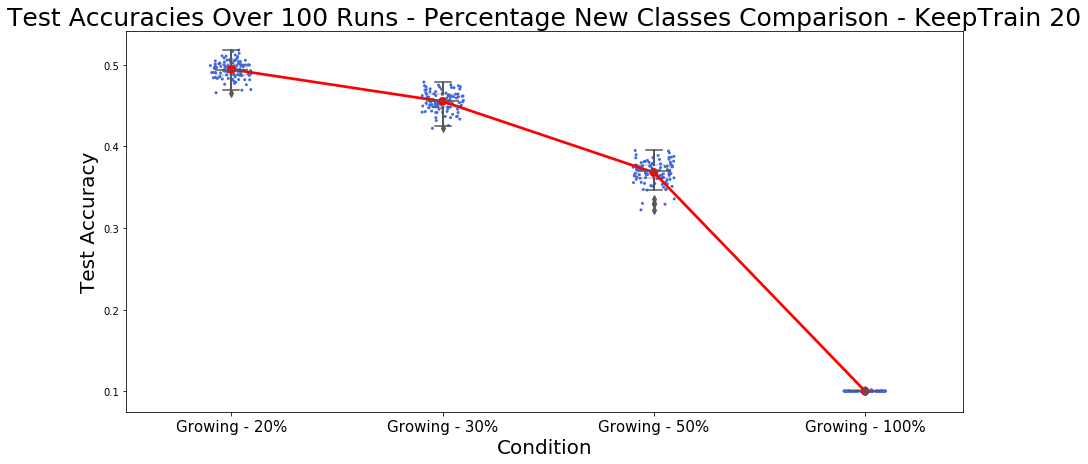

In [19]:
import ptitprince as pt
ax = pt.RainCloud(data=PerComp, x='Condition',y='Performance', palette=["royalblue"],bw = 0.0,
                 width_viol = .0, figsize = (15,7),pointplot=True,alpha = 0.3, dodge = True, move = 0.0)
ax.set_xticklabels(["Growing - 20%",'Growing - 30%','Growing - 50%','Growing - 100%'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Percentage New Classes Comparison - KeepTrain 20',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.show()
#plt.savefig("NewResults/PerfComp100xPercentage.png", bbox_inches='tight')